## Problem 2

<img src="2.jpg" width="50%" />

In [1]:
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

def V(n,
      attendance=np.array([4000, 4500, 5000, 5500, 6000]).reshape((-1,1)) + 1,
      prob=np.array([.1, .3, .3, .2, .1]).reshape((-1,1)),
      conversion_factor=.40,
      unit_cost=.30,
      unit_profit=.60,
      const_cost=200,
      ad_profit=300
     ):
    buyers = attendance * conversion_factor
    V = np.minimum(prob.T.dot(buyers), [n])* unit_profit + ad_profit - const_cost - n*unit_cost
    return np.asscalar(V)

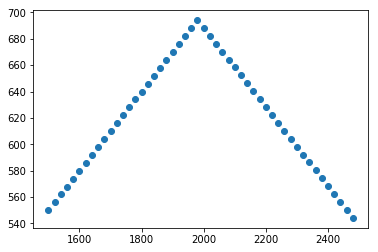

In [2]:
NN = list(range(1500, 2500, 20))
plt.scatter(NN, [V(n) for n in NN], )

In [3]:
import scipy as sp, scipy.optimize as opt

In [4]:
extr = opt.minimize_scalar(lambda n: -V(n), bounds=(1500, 2500), method='bounded')
extr

     fun: -694.1199961809798
 message: 'Solution found.'
    nfev: 23
  status: 0
 success: True
       x: 1980.3999872699326

In [5]:
V(1980)

694.0

**Следует заказать $1980$ программ**

In [6]:
p2V = lambda n: -V(n, attendance=np.array([5500]), prob=np.array([1.]), conversion_factor=1.) 
extr2 = opt.minimize_scalar(p2V)
extr2

     fun: -1749.9999958919673
    nfev: 26
     nit: 25
 success: True
       x: 5499.9999863065577

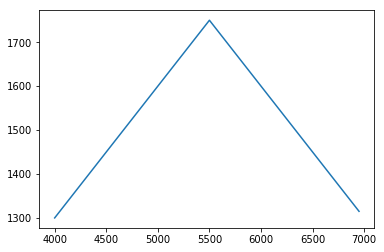

In [7]:
NN = list(range(4000, 7000, 50))
plt.plot(NN, -np.array([p2V(n) for n in NN]), )

**В условиях п. 2 следует заказать столько программ, сколько ожидается клиентов**

# Problem 3

<img src="3.jpg" width="50%" />
Из условия нельзя уверенно судить: определяется ли спрос в первые два года раз и навсегда,
или же спрос меняется каждый год (и эти изменения моделируются марковским процессом).

Для первого случая вручную нарисуем дерево, для второго --- посчитаем оценки на ЭВМ.

**NB**: в любом случае,
в поставленных условиях в хоть сколь-нибудь длительной перспективе
всегда выгоднее вклад под проценты,
так как он обеспечивает экспоненциальный рост,
а во всех остальных случаях темпы роста ограничены.


### Первый случай

<img src="3_tree.jpg" />

### Второй случай

In [8]:
def venture_net_gain(venture=1, server=1, high_demand=1):
    income = 5e5 if high_demand else 3e5
    income += 1
    if server:
        return income - (1.4e5+1) - (2e4+1)
    return income*.7 - (1.4e5+1)


class State:
    
    def __init__(self, balance=0, gain=0, year=0, high_demand=0, server=1, venture=1):
        self.balance = balance
        self.high_demand = high_demand
        self.server = server
        self.venture = venture
        self.year = year
        self.gain = gain
        self.branches = []
        self.avg_balance = 0
        self.avg_gain = 0
        
    def gen_next_steps(self):
        if self.venture:
            s1 = State(high_demand=1, venture=1, server=self.server, year=self.year+1)
            s2 = State(high_demand=0, venture=1, server=self.server, year=self.year+1)
            s1.gain = venture_net_gain(s1.server, s1.high_demand)
            s2.gain = venture_net_gain(s2.server, s2.high_demand)
            s1.balance = self.balance + s1.gain
            s2.balance = self.balance + s2.gain
            if self.high_demand:
                return [(.8, s1), (.2, s2)]
            return [(.4, s1), (.6, s2)]
        return State(balance=self.balance*1.3, year=self.year+1)
    
    def simulate(self, until=3):
        if self.year >= until:
            return
        if not self.branches:
            self.branches = self.gen_next_steps()
        self.avg_balance, self.avg_gain = 0, 0
        for p, b in self.branches:
            b.simulate(until=until)
            self.avg_gain += p*(b.gain + b.avg_gain)
            self.avg_balance += p*(b.balance + b.avg_balance)
        return self
    
    def __str__(self):
        return ('\n'.join([
            k + '=' + str(getattr(self, k))
            for k in ['year', 'venture', 'server', 'balance', 'gain', 'avg_gain', 'avg_balance']
        ]))
            
G = State()
G.branches.append([.5, State(venture=1, server=1, balance=-2e5-1.5e5)])
G.branches.append([.5, State(venture=1, server=0, balance=-2e5)])
G.simulate(until=3)

for p,b in G.branches:
    print(b)
    print()

year=0
venture=1
server=1
balance=-350000.0
gain=0
avg_gain=835917.9912
avg_balance=592716.1391999999

year=0
venture=1
server=0
balance=-200000.0
gain=0
avg_gain=835917.9912
avg_balance=1042716.1392000001



In [9]:
import collections

def print_flat_G(G):
    q = collections.deque([G])
    while q:
        G = q.popleft()
        for p, b in G.branches:
            q.append(b)
        print(G)
        print()
        
# print_flat_G(G)        




Статистики для первого случая:

In [10]:
.8*3.4e5*2 - .2*7e4

530000.0

In [11]:
3.4e5*2*.4 - .6*7e4

230000.0

In [12]:
(3.4e5 + 5.3e5)*.6 + (-7e4 + 2.3e5)*.4

586000.0

In [13]:
.6*(3.4e5*.8 - 7e4*.2) + .4*(.4*3.4e5 -.6*7e4)

192400.0

In [14]:
(
    .6 * (
        2.1e5 +
        .8*2.1e5*2 +
        .2*7e4*2
    ) +
    .4 * (
        7e4 +
        .4*2.1e5*2 +
        .6*7e4*2
    )
)

473200.0

In [15]:
(
    .6 * (
        .8*2.1e5 +
        .2*7e4
    ) +
    .4 * (
        .4*2.1e5 +
        .6*7e4
    )
)

159600.0

In [16]:
1.3**2 * 2e5

338000.00000000006

In [17]:
(1.3**2 - 1) * 2e5

138000.00000000003